# Pre-Processing & Modelling

We are here! We are finally here! I'm ready to build a model to predict SPI scores based on transfer spending data, after some pre-processing.

__What's Happened So Far:__
 - Found data to use. View it here.
 - Cleaned the transfers data. Notebook
 - Cleaned the SPI data. Notebook
 - Learned how to create new features!
 - Visualized the new features and looked at correlations. Notebook

Now, the moment of truth. 

As always, first steps are reading in the data and import libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
path = '/home/tdraths/sb_assignments/Transfers_Capstone/data/data_cleaning_outputs/SPI_Transfers_Features.csv'
df = pd.read_csv(path, index_col=0)
pd.set_option('display.max_columns', None)
display(df.shape)
df.sample(5)

(100, 26)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Most Purchased Position,Position Max Spend,Position Min Spend,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs
76,2019,TOT,Tottenham Hotspur,14,14,133650000.0,57600000.0,9.546429e+06,54000000.0,24300000.0,80.797895,80.935789,80.87,Attacking Midfielder,Attacking Midfielder,Left Winger,0.0,0.0,0.0,0.0,0.0,17100000.0,24150000.0,4950000.0,0.0,-3.89
93,2020,NEW,Newcastle,10,12,34880000.0,248000.0,3.488000e+06,20030000.0,248000.0,64.868421,64.776842,64.82,Goalkeeper,Striker,Left-Back,0.0,7425000.0,0.0,0.0,0.0,0.0,0.0,0.0,20030000.0,0.30
95,2020,SOU,Southampton,16,13,36270000.0,23670000.0,2.266875e+06,13500000.0,14940000.0,71.012632,71.021053,71.02,Defensive Midfielder,Defensive Midfielder,Right-Back,0.0,0.0,5985000.0,3600000.0,3375000.0,0.0,0.0,0.0,0.0,1.56
63,2019,BOU,AFC Bournemouth,13,13,50810000.0,30060000.0,3.908462e+06,16200000.0,20070000.0,66.601579,66.593684,66.60,Attacking Midfielder,Centre-Back,Left-Back,0.0,6660000.0,4010000.0,0.0,0.0,16200000.0,2970000.0,2430000.0,0.0,0.91
39,2017,WHU,West Ham United,16,22,51120000.0,62120000.0,3.195000e+06,20070000.0,20520000.0,55.925789,56.350000,56.14,Striker,Left Winger,Right Winger,2070000.0,0.0,0.0,0.0,0.0,2700000.0,270000.0,0.0,11317500.0,-5.40


In [3]:
display(df['Most Purchased Position'].value_counts())
display(df['Position Max Spend'].value_counts())
display(df['Position Min Spend'].value_counts())

Striker                 38
Attacking Midfielder    24
Centre-Back             13
Goalkeeper              10
Right Winger             7
Right-Back               4
Left Winger              2
Left-Back                1
Defensive Midfielder     1
Name: Most Purchased Position, dtype: int64

Striker                 24
Attacking Midfielder    20
Left Winger             15
Centre-Back             15
Right Winger            10
Defensive Midfielder     9
Left-Back                3
Goalkeeper               2
Right-Back               2
Name: Position Max Spend, dtype: int64

Striker                 20
Attacking Midfielder    17
Centre-Back             15
Right-Back              12
Goalkeeper               9
Defensive Midfielder     7
Left-Back                7
Right Winger             7
Left Winger              6
Name: Position Min Spend, dtype: int64

In [4]:
map_most_purchased = {
    'Right-Back': 'Other',
    'Left Winger': 'Other',
    'Defensive Midfielder': 'Other',
    'Left-Back': 'Other',
}

map_max_spend = {
    'Defensive Midfielder': 'Other',
    'Left-Back': 'Other',
    'Right-Back': 'Other',
    'Goalkeeper': 'Other'
}

map_min_spend = {
    'Left-Back': 'Other',
    'Right Winger': 'Other',
    'Defensive Midfielder': 'Other',
    'Left Winger': 'Other'
}

df['Most Purchased Position'] = df['Most Purchased Position'].replace(map_most_purchased)
df['Position Max Spend'] = df['Position Max Spend'].replace(map_max_spend)
df['Position Min Spend'] = df['Position Min Spend'].replace(map_min_spend)

display(df['Most Purchased Position'].value_counts())
display(df['Position Max Spend'].value_counts())
display(df['Position Min Spend'].value_counts())

Striker                 38
Attacking Midfielder    24
Centre-Back             13
Goalkeeper              10
Other                    8
Right Winger             7
Name: Most Purchased Position, dtype: int64

Striker                 24
Attacking Midfielder    20
Other                   16
Left Winger             15
Centre-Back             15
Right Winger            10
Name: Position Max Spend, dtype: int64

Other                   27
Striker                 20
Attacking Midfielder    17
Centre-Back             15
Right-Back              12
Goalkeeper               9
Name: Position Min Spend, dtype: int64

## Dummies for Days
Some of my new features are categorical, and describe the positions a team bought the most of, spent the most on and spent the least on, respectively. You can see these in `Most Purchased Position`, `Position Max Spend`, `Position Min Spend`.

Below, I define those columns in a list and then create a dataframe with my current `df` and the new dummy features. I'm surprised by how easy this is.

In [5]:
columns = ['Most Purchased Position', 'Position Max Spend', 'Position Min Spend']
df_dummies = pd.get_dummies(df, columns=columns)
display(df_dummies.shape)
df_dummies.sample()

(100, 41)

,Year,Team,Team Name,Total Transfers (In),Total Transfers (Out),Total Spent (In),Total Earned (Out),Average Fee (In),Max Fee Spent,Min Fee Spent,Average Home SPI Score,Average Away SPI Score,Average Season SPI Score,Average Spent on Goalkeeper,Average Spent on Left-Back,Average Spent on Right-Back,Average Spent on Centre-Back,Average Spent on Defensive Midfielder,Average Spent on Left Winger,Average Spent on Attacking Midfielder,Average Spent on Right Winger,Average Spent on Striker,spi_diffs,Most Purchased Position_Attacking Midfielder,Most Purchased Position_Centre-Back,Most Purchased Position_Goalkeeper,Most Purchased Position_Other,Most Purchased Position_Right Winger,Most Purchased Position_Striker,Position Max Spend_Attacking Midfielder,Position Max Spend_Centre-Back,Position Max Spend_Left Winger,Position Max Spend_Other,Position Max Spend_Right Winger,Position Max Spend_Striker,Position Min Spend_Attacking Midfielder,Position Min Spend_Centre-Back,Position Min Spend_Goalkeeper,Position Min Spend_Other,Position Min Spend_Right-Back,Position Min Spend_Striker
60,2019,ARS,Arsenal,15,20,144360000.0,47160000.0,9624000.0,72000000.0,27360000.0,77.786842,77.393684,77.59,0.0,24300000.0,0.0,14010000.0,0.0,2010000.0,0.0,36000000.0,0.0,-3.02,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [6]:
data = df_dummies.drop(columns=['Year', 'Team', 'Team Name'])

## II. Plotting feature distributions

#### Distributions of a few select features
The statistics above show that the features are on different scales. For example:
 - `Average Season SPI Score`:
      - Min: 47.33
      - Max: 94.88
      - Mean: 70.08
 - `Total Transfers (In)`:
      - Min: 4.0
      - Max: 39.0
      - Mean: 17.19
 - `Total Spent (In)`:
      - Min: 0.00
      - Max: 2.85 e+08
      - Mean: 7.83 e+07   
 

I'll visualize distributions for a few of the columns below.

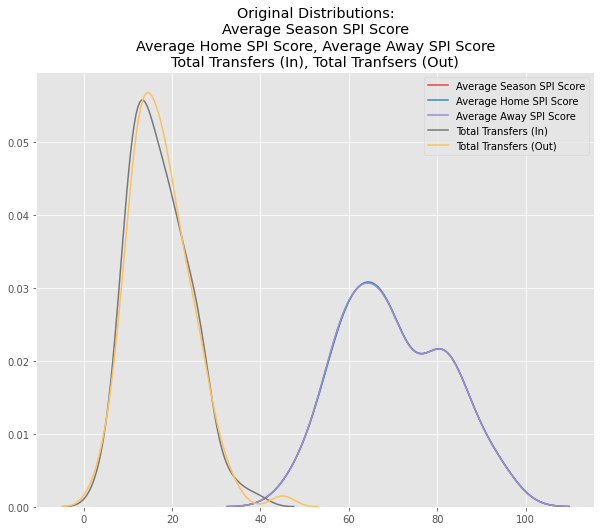

In [7]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title(
    "Original Distributions:\nAverage Season SPI Score\nAverage Home SPI Score, Average Away SPI Score\nTotal Transfers (In), Total Tranfsers (Out)")

sns.kdeplot(data['Average Season SPI Score'], ax=ax1)
sns.kdeplot(data['Average Home SPI Score'], ax=ax1)
sns.kdeplot(data['Average Away SPI Score'], ax=ax1)

sns.kdeplot(data['Total Transfers (In)'], ax=ax1)
sns.kdeplot(data['Total Transfers (Out)'], ax=ax1);

In the KDE Plot above, there are two distinct distributions, the left one representing the Total Transfer counts for clubs, and the right one showing the Average SPI Scores for clubs.

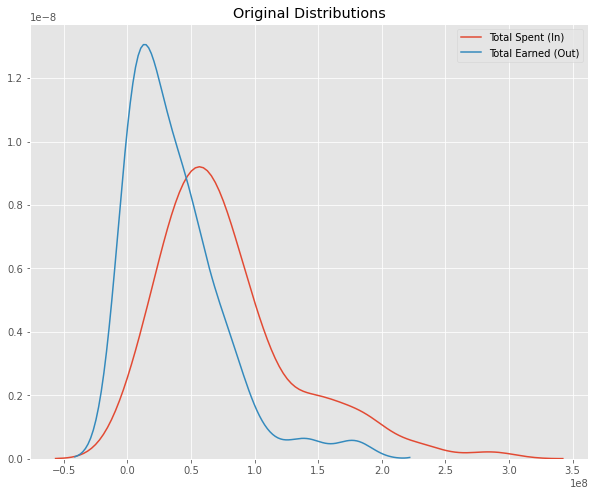

In [8]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

sns.kdeplot(data['Total Spent (In)'], ax=ax1)
sns.kdeplot(data['Total Earned (Out)'], ax=ax1);

In [9]:
X = data.drop(columns=['Average Season SPI Score'])
y = data['Average Season SPI Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
spi_X = data.drop(columns=['spi_diffs'])
spi_y = data['spi_diffs']

spi_X_train, spi_X_test, spi_y_train, spi_y_test = train_test_split(spi_X, spi_y, test_size=0.2, random_state=0)

In the KDE Plot above, Total Spent and Total Earned are on a completely difference scale from the previous plots. If I put them all together on the same axes, you'd see one straight vertical line near x=0. You can see that at the end of this section.

In [11]:
col_names = list(X_train.columns) # Will to use this list later in scaled DataFrames
col_names

spi_col_names = list(spi_X_train.columns)

## III. Trying Different Scalers
I'm new to this, and I'm not sure whether MinMax, RobustScaler, StandardScaler or another method is best for my data. In this section, I'm going to attempt MinMax, Robust and Standard and see which seems to make the most sense. In the cells below, I'll scale the X_train data and visualize the distribution of the scaled data. I'll also scale the X_test data for use later.

#### MinMaxScaler
 - Subtracts the column mean from each value and then divides by the column range.

In [12]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=col_names)

X_test_mm = mm_scaler.transform(X_test)

spi_X_train_mm = mm_scaler.fit_transform(spi_X_train)
spi_X_train_mm = pd.DataFrame(spi_X_train_mm, columns=spi_col_names)

spi_X_test_mm = mm_scaler.transform(spi_X_test)

#### RobustScaler
 - Subtracts the column median from each value and then divides by the column interquartile range.

In [13]:
r_scaler = preprocessing.RobustScaler()
X_train_r = r_scaler.fit_transform(X_train)
X_train_r = pd.DataFrame(X_train_r, columns=col_names)

X_test_r = r_scaler.transform(X_test)

spi_X_train_r = r_scaler.fit_transform(spi_X_train)
spi_X_train_r = pd.DataFrame(spi_X_train_r, columns=spi_col_names)

spi_X_test_r = r_scaler.transform(spi_X_test)

#### StandardScaler
 - Scales each column to unit variance by removing the mean.

In [14]:
s_scaler = preprocessing.StandardScaler()
X_train_s = s_scaler.fit_transform(X_train)
X_train_s = pd.DataFrame(X_train_s, columns=col_names)

X_test_s = s_scaler.transform(X_test)

spi_X_train_s = s_scaler.fit_transform(spi_X_train)
spi_X_train_s = pd.DataFrame(spi_X_train_s, columns=spi_col_names)

spi_X_test_s = s_scaler.transform(spi_X_test)

## IV. Putting it all together

Now that I've scaled the data, it's time to decide which method I'll use in my model. I've plotted the distributions of the original data of the three versions of scaled data below, using a few select columns.
 - `Average Home SPI Score`, `Average Away SPI Score`
 - `Total Transfers (In)`, `Total Transfers (Out)`
 - `Total Spent (In)`, `Total Earned (Out)`



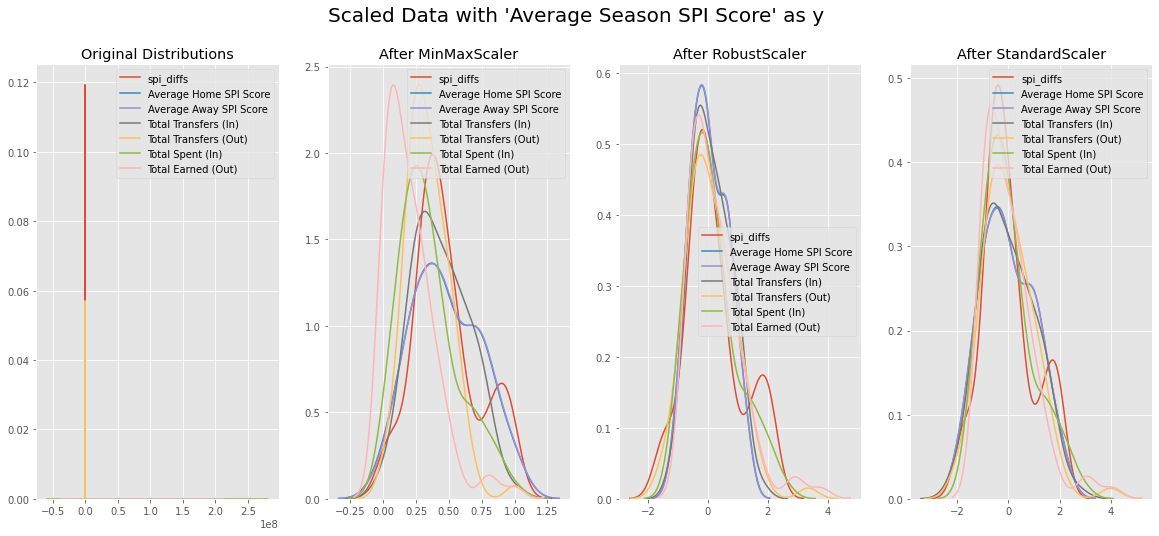

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20,8))
fig.suptitle("Scaled Data with 'Average Season SPI Score' as y", fontsize=20)


ax0.set_title('Original Distributions')
sns.kdeplot(X_train['spi_diffs'], ax=ax0)
sns.kdeplot(X_train['Average Home SPI Score'], ax=ax0)
sns.kdeplot(X_train['Average Away SPI Score'], ax=ax0)
sns.kdeplot(X_train['Total Transfers (In)'], ax=ax0)
sns.kdeplot(X_train['Total Transfers (Out)'], ax=ax0)
sns.kdeplot(X_train['Total Spent (In)'], ax=ax0)
sns.kdeplot(X_train['Total Earned (Out)'], ax=ax0);


ax1.set_title('After MinMaxScaler')
sns.kdeplot(X_train_mm['spi_diffs'], ax=ax1)
sns.kdeplot(X_train_mm['Average Home SPI Score'], ax=ax1)
sns.kdeplot(X_train_mm['Average Away SPI Score'], ax=ax1)
sns.kdeplot(X_train_mm['Total Transfers (In)'], ax=ax1)
sns.kdeplot(X_train_mm['Total Transfers (Out)'], ax=ax1)
sns.kdeplot(X_train_mm['Total Spent (In)'], ax=ax1)
sns.kdeplot(X_train_mm['Total Earned (Out)'], ax=ax1);


ax2.set_title('After RobustScaler')
sns.kdeplot(X_train_r['spi_diffs'], ax=ax2)
sns.kdeplot(X_train_r['Average Home SPI Score'], ax=ax2)
sns.kdeplot(X_train_r['Average Away SPI Score'], ax=ax2)
sns.kdeplot(X_train_r['Total Transfers (In)'], ax=ax2)
sns.kdeplot(X_train_r['Total Transfers (Out)'], ax=ax2)
sns.kdeplot(X_train_r['Total Spent (In)'], ax=ax2)
sns.kdeplot(X_train_r['Total Earned (Out)'], ax=ax2);


ax3.set_title('After StandardScaler')
sns.kdeplot(X_train_s['spi_diffs'], ax=ax3)
sns.kdeplot(X_train_s['Average Home SPI Score'], ax=ax3)
sns.kdeplot(X_train_s['Average Away SPI Score'], ax=ax3)
sns.kdeplot(X_train_s['Total Transfers (In)'], ax=ax3)
sns.kdeplot(X_train_s['Total Transfers (Out)'], ax=ax3)
sns.kdeplot(X_train_s['Total Spent (In)'], ax=ax3)
sns.kdeplot(X_train_s['Total Earned (Out)'], ax=ax3);

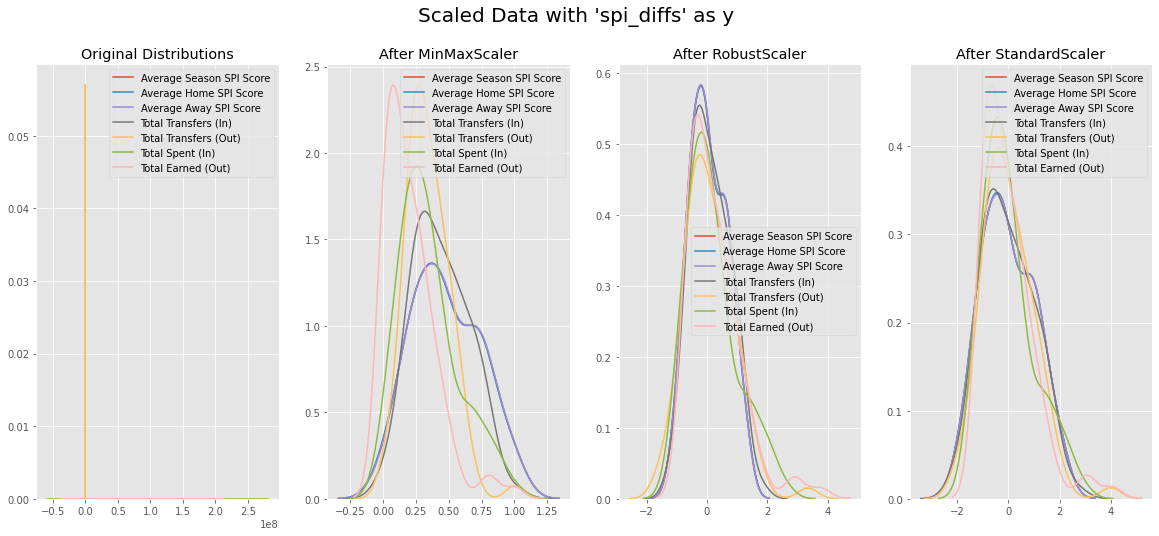

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20,8))
fig.suptitle("Scaled Data with 'spi_diffs' as y", fontsize=20)

ax0.set_title('Original Distributions')
sns.kdeplot(spi_X_train['Average Season SPI Score'], ax=ax0)
sns.kdeplot(spi_X_train['Average Home SPI Score'], ax=ax0)
sns.kdeplot(spi_X_train['Average Away SPI Score'], ax=ax0)
sns.kdeplot(spi_X_train['Total Transfers (In)'], ax=ax0)
sns.kdeplot(spi_X_train['Total Transfers (Out)'], ax=ax0)
sns.kdeplot(spi_X_train['Total Spent (In)'], ax=ax0)
sns.kdeplot(spi_X_train['Total Earned (Out)'], ax=ax0);


ax1.set_title('After MinMaxScaler')
sns.kdeplot(spi_X_train_mm['Average Season SPI Score'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Average Home SPI Score'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Average Away SPI Score'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Transfers (In)'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Transfers (Out)'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Spent (In)'], ax=ax1)
sns.kdeplot(spi_X_train_mm['Total Earned (Out)'], ax=ax1);


ax2.set_title('After RobustScaler')
sns.kdeplot(spi_X_train_r['Average Season SPI Score'], ax=ax2)
sns.kdeplot(spi_X_train_r['Average Home SPI Score'], ax=ax2)
sns.kdeplot(spi_X_train_r['Average Away SPI Score'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Transfers (In)'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Transfers (Out)'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Spent (In)'], ax=ax2)
sns.kdeplot(spi_X_train_r['Total Earned (Out)'], ax=ax2);


ax3.set_title('After StandardScaler')
sns.kdeplot(spi_X_train_s['Average Season SPI Score'], ax=ax3)
sns.kdeplot(spi_X_train_s['Average Home SPI Score'], ax=ax3)
sns.kdeplot(spi_X_train_s['Average Away SPI Score'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Transfers (In)'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Transfers (Out)'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Spent (In)'], ax=ax3)
sns.kdeplot(spi_X_train_s['Total Earned (Out)'], ax=ax3);

In [17]:
X_train = X_train_mm
X_test = X_test_mm

spi_X_train = spi_X_train_mm
spi_X_test = spi_X_test_mm

## V. Training Algorithms

As I mentioned above, I'm new to this, so I'm going to try as many algorithms as I can to model predictions based on my SPI/Transfers data. I've split the data into X/Y Train/Test sets and I have scaled `X_train` and `X_test` using a MinMax scaler. Now, I'll work through a process to fit and predict using as many algorithms as I can!

### Linear Regression - OLS & NNLS

In [18]:
from sklearn import linear_model
from sklearn.metrics import r2_score, median_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score

model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

model_season = model.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = model.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 1.0
MAE: 0.0028


SPI model score: -0.4022
MAE: 3.3835


In [19]:
reg_nnls = linear_model.LinearRegression(fit_intercept=True, positive=True)

model_season = reg_nnls.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = reg_nnls.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 1.0
MAE: 0.0024


SPI model score: -0.5924
MAE: 2.6768


### ElasticNet

In [20]:
elastic_net = linear_model.ElasticNet(random_state=0)

model_season = elastic_net.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = elastic_net.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 0.3959
MAE: 7.2997


SPI model score: -0.1551
MAE: 2.2021


### LARS

In [21]:
lars = linear_model.Lars(n_nonzero_coefs=1)

model_season = lars.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = lars.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 0.0046
MAE: 9.1143


SPI model score: -0.1531
MAE: 2.2011


### Bayesian Ridge Regression

In [22]:
bayes = linear_model.BayesianRidge()

model_season = bayes.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = bayes.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 1.0
MAE: 0.0028


SPI model score: -0.1553
MAE: 2.2021


### Support Vector Regression

In [23]:
from sklearn import svm
support_vector = svm.SVR()

model_season = support_vector.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = support_vector.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 0.2239
MAE: 8.2377


SPI model score: -0.1031
MAE: 2.2795


### Gaussian Process Regressor

In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#kernel = DotProduct() + WhiteKernel()

gaussian = gpr(random_state=0, normalize_y=True)

model_season = gaussian.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = gaussian.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 0.6258
MAE: 3.4842


SPI model score: -0.5305
MAE: 1.9228


### Partial Least Squares Regressor

In [25]:
from sklearn.cross_decomposition import PLSRegression as pls2

pls = pls2()

model_season = pls.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = pls.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: 0.9329
MAE: 1.4965


SPI model score: -0.6154
MAE: 3.3881


### Partial Least Squares Canonical 

In [28]:
from sklearn.cross_decomposition import PLSCanonical as plsca

pls_canon = plsca()

model_season = pls_canon.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = pls_canon.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

print('Season model score:', round(score_season, 4))
print('MAE:', round(mae_season, 4))

print('\n')

print('SPI model score:', round(score_spi, 4))
print('MAE:', round(mae_spi, 4))

Season model score: -1.6995
MAE: 12.1957


SPI model score: -2.0663
MAE: 5.4311


### Decision Tree Regression

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

model_season = tree.fit(X_train, y_train)
y_pred_season = model_season.predict(X_test)
score_season = r2_score(y_test, y_pred_season)
mae_season = median_absolute_error(y_test, y_pred_season)

model_spi = tree.fit(spi_X_train, spi_y_train)
y_pred_spi = model_spi.predict(spi_X_test)
score_spi = r2_score(spi_y_test, y_pred_spi)
mae_spi = median_absolute_error(spi_y_test, y_pred_spi)

In [30]:
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_8 = DecisionTreeRegressor(max_depth=8)

season_2 = tree_2.fit(X_train, y_train)
pred_season_2 = season_2.predict(X_test)
score_season_2 = r2_score(y_test, pred_season_2)
mae_season_2 = median_absolute_error(y_test, pred_season_2)

spi_2 = tree_2.fit(spi_X_train, spi_y_train)
pred_spi_2 = spi_2.predict(spi_X_test)
score_spi_2 = r2_score(spi_y_test, pred_spi_2)
mae_spi_2 = median_absolute_error(spi_y_test, pred_spi_2)

season_5 = tree_5.fit(X_train, y_train)
pred_season_5 = season_5.predict(X_test)
score_season_5 = r2_score(y_test, pred_season_5)
mae_season_5 = median_absolute_error(y_test, pred_season_5)

spi_5 = tree_5.fit(spi_X_train, spi_y_train)
pred_spi_5 = spi_5.predict(spi_X_test)
score_spi_5 = r2_score(spi_y_test, pred_spi_5)
mae_spi_5 = median_absolute_error(spi_y_test, pred_spi_5)

season_8 = tree_8.fit(X_train, y_train)
pred_season_8 = season_8.predict(X_test)
score_season_8 = r2_score(y_test, pred_season_8)
mae_season_8 = median_absolute_error(y_test, pred_season_8)

spi_8 = tree_8.fit(spi_X_train, spi_y_train)
pred_spi_8 = spi_8.predict(spi_X_test)
score_spi_8 = r2_score(spi_y_test, pred_spi_8)
mae_spi_8 = median_absolute_error(spi_y_test, pred_spi_8)

print('DecisionTree Models with Default Max Depth')
print('\tSeason model score:', round(score_season, 4))
print('\tSeason MAE:', round(mae_season, 4))

print('\tSPI model score:', round(score_spi, 4))
print('\tSPI MAE:', round(mae_spi, 4))

print('\n')

print('DecisionTree Models with Max Depth of 2')
print('\tSeason model score:', round(score_season_2, 4))
print('\tSeason MAE:', round(mae_season_2, 4))

print('\tSPI model score:', round(score_spi_2, 4))
print('\tSPI MAE:', round(mae_spi_2, 4))

print('\n')

print('DecisionTree Models with Max Depth of 5')
print('\tSeason model score:', round(score_season_5, 4))
print('\tSeason MAE:', round(mae_season_5, 4))

print('\tSPI model score:', round(score_spi_5, 4))
print('\tSPI MAE:', round(mae_spi_5, 4))

print('\n')

print('DecisionTree Models with Max Depth of 8')
print('\tSeason model score:', round(score_season_8, 4))
print('\tSeason MAE:', round(mae_season_8, 4))

print('\tSPI model score:', round(score_spi_8, 4))
print('\tSPI MAE:', round(mae_spi_8, 4))

DecisionTree Models with Default Max Depth
	Season model score: 0.9757
	Season MAE: 0.52
	SPI model score: -0.773
	SPI MAE: 3.4612


DecisionTree Models with Max Depth of 2
	Season model score: 0.9021
	Season MAE: 2.715
	SPI model score: -0.3567
	SPI MAE: 2.7878


DecisionTree Models with Max Depth of 5
	Season model score: 0.9863
	Season MAE: 0.865
	SPI model score: -0.5536
	SPI MAE: 3.9308


DecisionTree Models with Max Depth of 8
	Season model score: 0.9866
	Season MAE: 0.51
	SPI model score: -0.8222
	SPI MAE: 2.985


### Decision Trees with AdaBoost

In [48]:
from sklearn.ensemble import AdaBoostRegressor

default_ada = AdaBoostRegressor(tree, n_estimators=300, random_state=1)

season_default_ada = default_ada.fit(X_train, y_train)
pred_season_ada = season_default_ada.predict(X_test)
score_season_ada = r2_score(y_test, pred_season_ada)
mae_season_ada = median_absolute_error(y_test, pred_season_ada)

spi_default_ada = default_ada.fit(spi_X_train, spi_y_train)
pred_spi_ada = spi_default_ada.predict(spi_X_test)
score_spi_ada = r2_score(spi_y_test, pred_spi_ada)
mae_spi_ada = median_absolute_error(spi_y_test, pred_spi_ada)


ada_2 = AdaBoostRegressor(tree_2, n_estimators=300, random_state=1)

season_ada_2 = ada_2.fit(X_train, y_train)
pred_season_ada_2 = season_ada_2.predict(X_test)
score_season_ada_2 = r2_score(y_test, pred_season_ada_2)
mae_season_ada_2 = median_absolute_error(y_test, pred_season_ada_2)

spi_ada_2 = ada_2.fit(spi_X_train, spi_y_train)
pred_spi_ada_2 = spi_ada_2.predict(spi_X_test)
score_spi_ada_2 = r2_score(spi_y_test, pred_spi_ada_2)
mae_spi_ada_2 = median_absolute_error(spi_y_test, pred_spi_ada_2)


ada_5 = AdaBoostRegressor(tree_5, n_estimators=300, random_state=1)

season_ada_5 = ada_5.fit(X_train, y_train)
pred_season_ada_5 = season_ada_5.predict(X_test)
score_season_ada_5 = r2_score(y_test, pred_season_ada_5)
mae_season_ada_5 = median_absolute_error(y_test, pred_season_ada_5)

spi_ada_5 = ada_5.fit(spi_X_train, spi_y_train)
pred_spi_ada_5 = spi_ada_5.predict(spi_X_test)
score_spi_ada_5 = r2_score(spi_y_test, pred_spi_ada_5)
mae_spi_ada_5 = median_absolute_error(spi_y_test, pred_spi_ada_5)


ada_8 = AdaBoostRegressor(tree_8, n_estimators=300, random_state=1)

season_ada_8 = ada_8.fit(X_train, y_train)
pred_season_ada_8 = season_ada_8.predict(X_test)
score_season_ada_8 = r2_score(y_test, pred_season_ada_8)
mae_season_ada_8 = median_absolute_error(y_test, pred_season_ada_8)

spi_ada_8 = ada_8.fit(spi_X_train, spi_y_train)
pred_spi_ada_8 = spi_ada_8.predict(spi_X_test)
score_spi_ada_8 = r2_score(spi_y_test, pred_spi_ada_8)
mae_spi_ada_8 = median_absolute_error(spi_y_test, pred_spi_ada_8)

print('ADABoosted - DecisionTree Models with Default Max Depth')
print('\tSeason model score:', round(score_season_ada, 4))
print('\tSeason MAE:', round(mae_season_ada, 4))

print('\tSPI model score:', round(score_spi_ada, 4))
print('\tSPI MAE:', round(mae_spi_ada, 4))

print('\n')

print('ADABoosted - DecisionTree Models with Max Depth of 2')
print('\tSeason model score:', round(score_season_ada_2, 4))
print('\tSeason MAE:', round(mae_season_ada_2, 4))

print('\tSPI model score:', round(score_spi_ada_2, 4))
print('\tSPI MAE:', round(mae_spi_ada_2, 4))

print('\n')

print('ADABoosted - DecisionTree Models with Max Depth of 5')
print('\tSeason model score:', round(score_season_ada_5, 4))
print('\tSeason MAE:', round(mae_season_ada_5, 4))

print('\tSPI model score:', round(score_spi_ada_5, 4))
print('\tSPI MAE:', round(mae_spi_ada_5, 4))

print('\n')

print('ADABoosted - DecisionTree Models with Max Depth of 8')
print('\tSeason model score:', round(score_season_ada_8, 4))
print('\tSeason MAE:', round(mae_season_ada_8, 4))

print('\tSPI model score:', round(score_spi_ada_8, 4))
print('\tSPI MAE:', round(mae_spi_ada_8, 4))

ADABoosted - DecisionTree Models with Default Max Depth
	Season model score: 0.9867
	Season MAE: 0.325
	SPI model score: -0.1586
	SPI MAE: 2.7475


ADABoosted - DecisionTree Models with Max Depth of 2
	Season model score: 0.9484
	Season MAE: 1.455
	SPI model score: -0.3268
	SPI MAE: 3.0447


ADABoosted - DecisionTree Models with Max Depth of 5
	Season model score: 0.9895
	Season MAE: 0.355
	SPI model score: -0.0892
	SPI MAE: 2.6468


ADABoosted - DecisionTree Models with Max Depth of 8
	Season model score: 0.9895
	Season MAE: 0.325
	SPI model score: -0.0972
	SPI MAE: 2.8815


### Gradient Tree Boosting (GradientBoostingRegressor)

In [51]:
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 
          'max_depth': 4, 
          'min_samples_split': 5, 
          'learning_rate': 0.01, 
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
score = r2_score(y_test, reg.predict(X_test))

print('Score:', score)
print('MSE:', mse)



Score: 0.9948921596991419
MSE: 0.4931505394855799


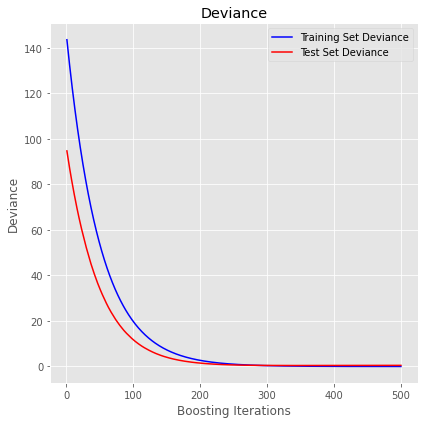

In [52]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()


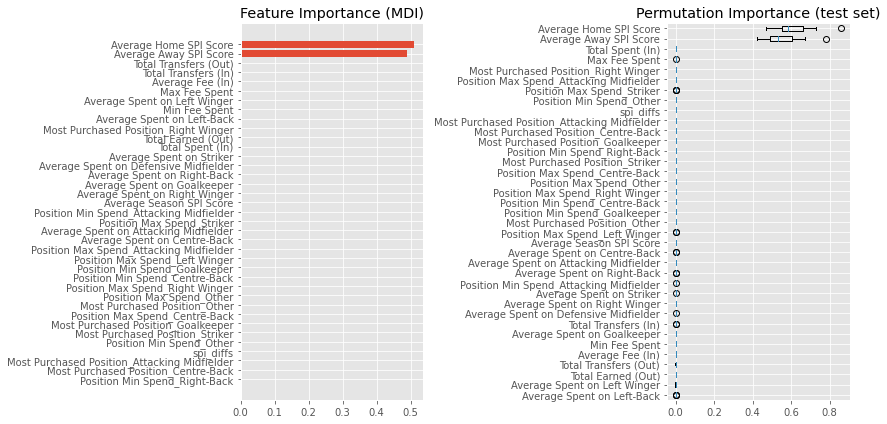

In [53]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()


Score: -0.41557664555706886
MSE: 30.9430600575305


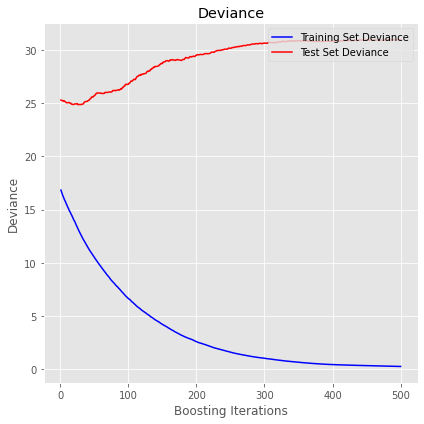

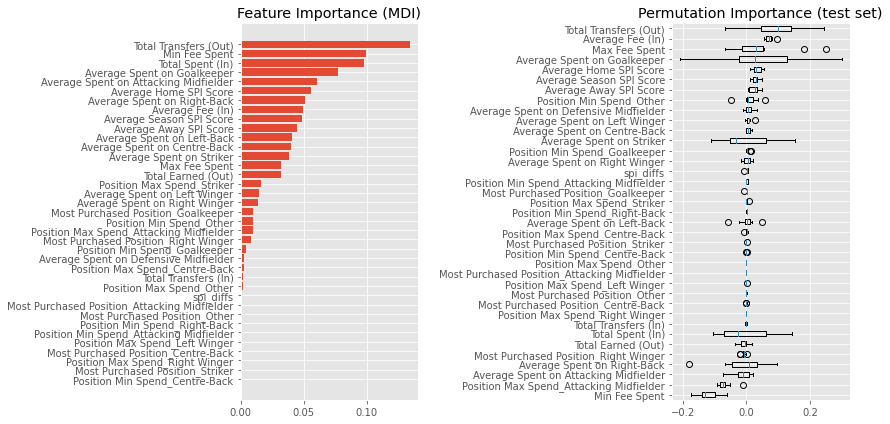

In [54]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(spi_X_train, spi_y_train)

mse = mean_squared_error(spi_y_test, reg.predict(spi_X_test))
score = r2_score(spi_y_test, reg.predict(spi_X_test))

print('Score:', score)
print('MSE:', mse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(spi_X_test)):
    test_score[i] = reg.loss_(spi_y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()


feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, spi_X_test, spi_y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()